In [41]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [42]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [43]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30T03:46:53.207Z,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30T03:44:08.272Z,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30T03:37:46.570Z,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30T03:32:41.102Z,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [44]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30 03:46:53.207000+00:00,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30 03:44:08.272000+00:00,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30 03:37:46.570000+00:00,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30 03:32:41.102000+00:00,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [45]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [46]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [47]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.10750,1.100000,1.30,1.641433e+09
1,38.181000,-117.81800,7.300000,1.40,1.641433e+09
2,61.340700,-149.88520,30.000000,1.50,1.641432e+09
3,62.870300,-150.76250,111.300000,2.10,1.641432e+09
4,64.014500,-148.76570,1.900000,1.50,1.641431e+09
...,...,...,...,...,...
28330,63.278200,-151.25170,7.400000,1.00,1.643514e+09
28331,67.671500,-160.82990,6.200000,2.90,1.643514e+09
28332,19.221167,-155.38916,31.940001,1.83,1.643514e+09
28333,2.757300,128.23460,53.450000,4.50,1.643514e+09


In [48]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [49]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [50]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [51]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['depth'], axis = 1)

y = cleaned_df_dropped[['depth']]

In [52]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((28329, 4), (28329, 1))

In [53]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [55]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 942.803412679327, 	R2 score: 0.6963213713320888, 	Model score: 0.6963213713320888
n_estimators=3:
	Mean Squared Error: 815.1893857963918, 	R2 score: 0.737426072653085, 	Model score: 0.737426072653085
n_estimators=4:
	Mean Squared Error: 770.4919696074414, 	R2 score: 0.751823188606118, 	Model score: 0.751823188606118
n_estimators=5:
	Mean Squared Error: 763.733416329214, 	R2 score: 0.7540001304411907, 	Model score: 0.7540001304411907
n_estimators=6:
	Mean Squared Error: 737.1249933577054, 	R2 score: 0.762570750032013, 	Model score: 0.762570750032013
n_estimators=7:
	Mean Squared Error: 728.998976352069, 	R2 score: 0.7651881543260757, 	Model score: 0.7651881543260757
n_estimators=8:
	Mean Squared Error: 685.2497737412747, 	R2 score: 0.7792798490266754, 	Model score: 0.7792798490266754
n_estimators=9:
	Mean Squared Error: 675.2099558101395, 	R2 score: 0.7825136919470549, 	Model score: 0.7825136919470549
n_estimators=10:
	Mean Squared Error: 660.4783204

In [56]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,200):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 50:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 942.803412679327, 	R2: 0.6963213713320888, 	Model score: 0.6963213713320888
n_estimators=3:
	Mean Squared Error: 815.1893857963918, 	R2: 0.737426072653085, 	Model score: 0.737426072653085
n_estimators=4:
	Mean Squared Error: 770.4919696074414, 	R2: 0.751823188606118, 	Model score: 0.751823188606118
n_estimators=5:
	Mean Squared Error: 763.733416329214, 	R2: 0.7540001304411907, 	Model score: 0.7540001304411907
n_estimators=6:
	Mean Squared Error: 737.1249933577054, 	R2: 0.762570750032013, 	Model score: 0.762570750032013
n_estimators=7:
	Mean Squared Error: 728.998976352069, 	R2: 0.7651881543260757, 	Model score: 0.7651881543260757
n_estimators=8:
	Mean Squared Error: 685.2497737412747, 	R2: 0.7792798490266754, 	Model score: 0.7792798490266754
n_estimators=9:
	Mean Squared Error: 675.2099558101395, 	R2: 0.7825136919470549, 	Model score: 0.7825136919470549
n_estimators=10:
	Mean Squared Error: 660.4783204100801, 	R2: 0.7872587774825559, 	Model score: 0

Cross-Validation

In [57]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 2833  2834  2835 ... 28326 28327 28328] | test: [   0    1    2 ... 2830 2831 2832]
Train: [    0     1     2 ... 28326 28327 28328] | test: [2833 2834 2835 ... 5663 5664 5665]
Train: [    0     1     2 ... 28326 28327 28328] | test: [5666 5667 5668 ... 8496 8497 8498]
Train: [    0     1     2 ... 28326 28327 28328] | test: [ 8499  8500  8501 ... 11329 11330 11331]
Train: [    0     1     2 ... 28326 28327 28328] | test: [11332 11333 11334 ... 14162 14163 14164]
Train: [    0     1     2 ... 28326 28327 28328] | test: [14165 14166 14167 ... 16995 16996 16997]
Train: [    0     1     2 ... 28326 28327 28328] | test: [16998 16999 17000 ... 19828 19829 19830]
Train: [    0     1     2 ... 28326 28327 28328] | test: [19831 19832 19833 ... 22661 22662 22663]
Train: [    0     1     2 ... 28326 28327 28328] | test: [22664 22665 22666 ... 25494 25495 25496]
Train: [    0     1     2 ... 25494 25495 25496] | test: [25497 25498 25499 ... 28326 28327 28328]


In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[0.76924953 0.73542852 0.71930564 0.77421571 0.87524891 0.69695545
 0.82198483 0.79756133 0.84842849 0.82025239]


In [59]:
reg_etrees = ExtraTreesRegressor(n_estimators=200, random_state=0)

In [60]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 200, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

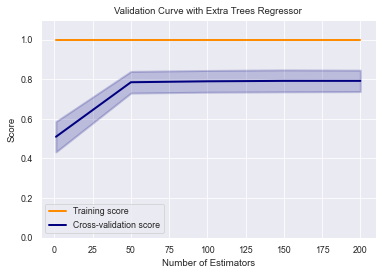

In [61]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [62]:
testpred = best_model.predict(X_test)
actual_lon = y_test
testpredict = []
for item in testpred:
    testpredict.append(item)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 24.303853


In [63]:
print(actual_lon)

       depth
8870    1.72
3587    8.81
6356   17.79
11229   2.71
2900   33.50
...      ...
5282    6.70
13083  13.20
21510   4.62
25047  10.00
19988   7.00

[9349 rows x 1 columns]


In [64]:
lon_pred = actual_lon
lon_pred['Predicted'] = testpredict


In [65]:
lon_pred_all = lon_pred.rename(columns={'depth': 'Actual'})

In [66]:
lon_pred_all

,Actual,Predicted
8870,1.72,1.594898
3587,8.81,6.498571
6356,17.79,60.716735
11229,2.71,3.349388
2900,33.50,25.634694
...,...,...
5282,6.70,6.406122
13083,13.20,9.026531
21510,4.62,3.123061
25047,10.00,37.484286


In [67]:
lon_pred_all = lon_pred.merge(cleaned_df, how='inner', left_index=True, right_index=True)
lon_pred_all = lon_pred_all.rename(columns={'depth_x': 'Actual', 'depth_y': 'depth'})
lon_pred_all

,Actual,Predicted,latitude,longitude,depth,mag,Unix Time
8870,1.72,1.594898,38.787000,-122.734167,1.72,0.12,1.641518e+09
3587,8.81,6.498571,38.230500,-112.381000,8.81,1.95,1.640179e+09
6356,17.79,60.716735,-28.686100,-71.555500,17.79,5.50,1.639456e+09
11229,2.71,3.349388,37.627667,-118.893500,2.71,0.11,1.643183e+09
2900,33.50,25.634694,62.446400,-148.337100,33.50,1.70,1.640377e+09
...,...,...,...,...,...,...,...
5282,6.70,6.406122,38.556100,-119.467700,6.70,0.90,1.639748e+09
13083,13.20,9.026531,38.167000,-117.875700,13.20,0.80,1.642671e+09
21510,4.62,3.123061,46.192000,-122.202333,4.62,-0.20,1.645033e+09
25047,10.00,37.484286,7.367500,-80.497000,10.00,4.60,1.644172e+09


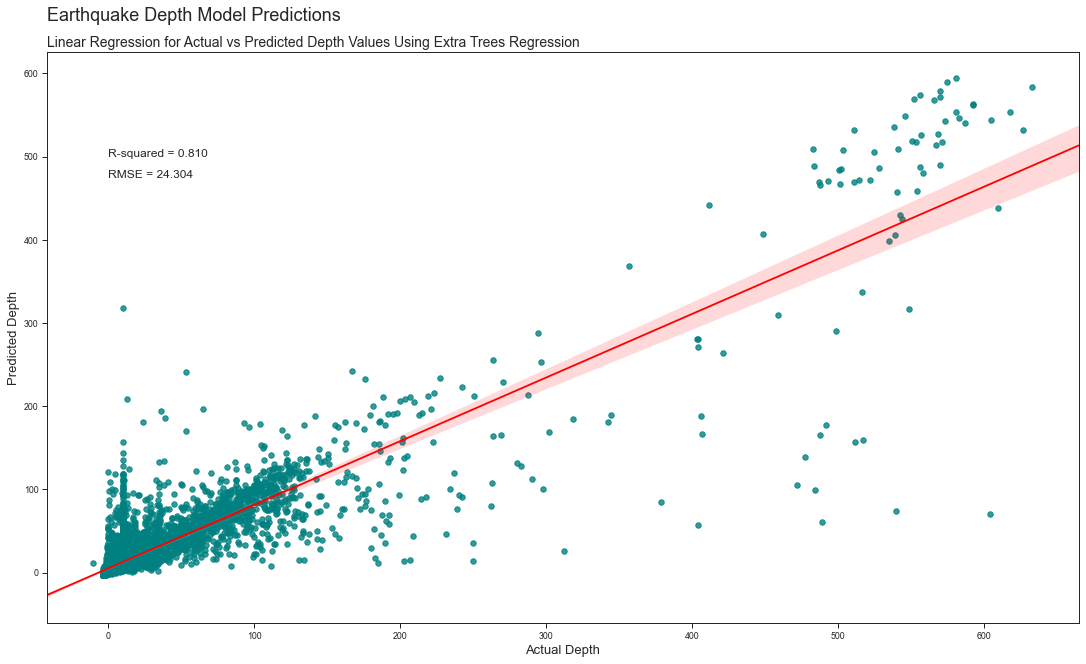

In [68]:
x = np.array(lon_pred_all['depth'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Depth', fontsize=13)
plt.xlabel('Actual Depth',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Depth Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Depth Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lon_pred_all['depth'], testpredict)), (0, 500),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 475), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS


In [69]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-04T01:37:12.230Z,33.415000,-116.428000,14.23,1.34,ml,55.0,57.00,0.108100,0.2000,...,2022-03-04T01:48:00.200Z,"18km NNW of Borrego Springs, CA",earthquake,0.25,0.42,0.223000,26.0,automatic,ci,ci
1,2022-03-04T01:36:23.340Z,33.123167,-116.545333,13.13,1.16,ml,31.0,55.00,0.060750,0.3000,...,2022-03-04T01:39:58.569Z,"7km NE of Julian, CA",earthquake,0.45,0.98,0.111000,26.0,automatic,ci,ci
2,2022-03-04T01:27:38.360Z,33.371667,-116.877667,6.90,0.63,ml,19.0,76.00,0.021960,0.3000,...,2022-03-04T01:31:09.025Z,"2km NW of Palomar Observatory, CA",earthquake,0.58,0.87,0.110000,16.0,automatic,ci,ci
3,2022-03-04T01:24:52.500Z,59.482900,-152.873900,91.70,1.90,ml,NaN,NaN,NaN,0.4500,...,2022-03-04T01:30:50.033Z,"55 km WNW of Nanwalek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
4,2022-03-04T01:18:41.980Z,34.313500,-116.448167,9.37,1.11,ml,13.0,76.00,0.058580,0.1100,...,2022-03-04T01:22:20.540Z,"22km N of Yucca Valley, CA",earthquake,0.28,0.48,0.180000,17.0,automatic,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2022-03-03T02:12:26.270Z,19.171499,-155.486664,35.59,2.40,md,46.0,92.00,NaN,0.1200,...,2022-03-03T02:15:36.990Z,"3 km SSW of Pāhala, Hawaii",earthquake,0.53,0.81,1.230000,23.0,automatic,hv,hv
288,2022-03-03T02:08:38.240Z,38.806332,-122.790832,0.33,0.97,md,20.0,48.00,0.003856,0.0300,...,2022-03-03T02:25:16.593Z,"4km NW of The Geysers, CA",earthquake,0.17,0.37,0.160000,5.0,automatic,nc,nc
289,2022-03-03T01:55:47.994Z,38.370300,-118.693400,8.30,0.60,ml,7.0,307.54,0.190000,0.0118,...,2022-03-04T01:12:34.791Z,"18 km SSW of Hawthorne, Nevada",earthquake,NaN,73.90,0.000000,1.0,reviewed,nn,nn
290,2022-03-03T01:49:43.240Z,38.825500,-122.854835,2.58,0.87,md,10.0,82.00,0.002589,0.0100,...,2022-03-03T02:14:17.521Z,"10km WNW of The Geysers, CA",earthquake,0.41,0.91,NaN,1.0,automatic,nc,nc


In [70]:


test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix Time
0,33.415000,-116.428000,14.23,1.34,1.646358e+09
1,33.123167,-116.545333,13.13,1.16,1.646358e+09
2,33.371667,-116.877667,6.90,0.63,1.646357e+09
3,59.482900,-152.873900,91.70,1.90,1.646357e+09
4,34.313500,-116.448167,9.37,1.11,1.646357e+09
...,...,...,...,...,...
287,19.171499,-155.486664,35.59,2.40,1.646274e+09
288,38.806332,-122.790832,0.33,0.97,1.646273e+09
289,38.370300,-118.693400,8.30,0.60,1.646273e+09
290,38.825500,-122.854835,2.58,0.87,1.646272e+09


In [71]:


#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [72]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['depth'], axis = 1)

y_test_data = cleaned_test_df[['depth']]


In [73]:

pred_data_y = best_model.predict(X_test_data)


In [74]:

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,33.415000,-116.428000,14.23,1.34,1.646358e+09,10.058571
1,33.123167,-116.545333,13.13,1.16,1.646358e+09,11.262653
2,33.371667,-116.877667,6.90,0.63,1.646357e+09,7.503265
3,59.482900,-152.873900,91.70,1.90,1.646357e+09,91.826531
4,34.313500,-116.448167,9.37,1.11,1.646357e+09,6.275714
...,...,...,...,...,...,...
287,19.171499,-155.486664,35.59,2.40,1.646274e+09,33.595102
288,38.806332,-122.790832,0.33,0.97,1.646273e+09,1.355306
289,38.370300,-118.693400,8.30,0.60,1.646273e+09,8.117551
290,38.825500,-122.854835,2.58,0.87,1.646272e+09,1.847143


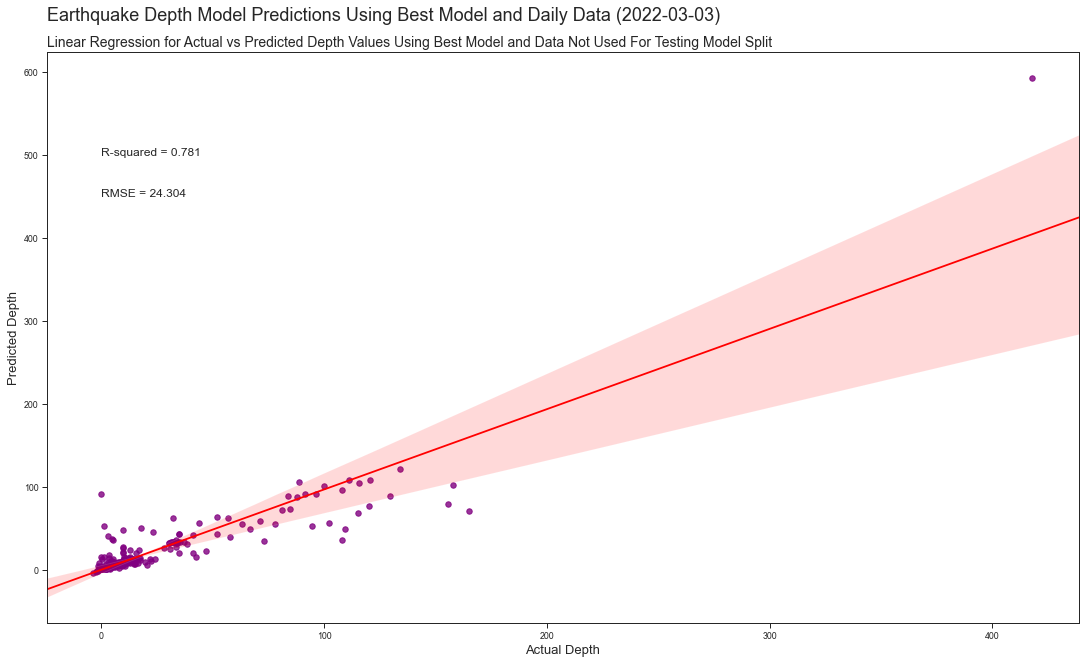

In [76]:

x = np.array(test_pred_data['depth'])
y = np.array(pred_data_y)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Depth', fontsize=13)
plt.xlabel('Actual Depth',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Depth Model Predictions Using Best Model and Daily Data (2022-03-03)', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Depth Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 500),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 450), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()